In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# iFood Offer Personalization: Propensity Modeling & Business Impact Analysis

### Introduction

This notebook documents the development and evaluation of a machine learning model designed to optimize iFood's marketing campaigns. Building upon the insights from the initial exploratory data analysis, our goal is to predict the likelihood of a customer completing a given offer. The ultimate objective is to create a data-driven tool that can assist in the strategic decision of **which offer to send to which customer**, aiming to increase conversion rates and maximizing the financial return on marketing investments.

This summary outlines the feature engineering process, presents the model's performance on a holdout test set, and translates these results into a tangible business impact.

### Feature Engineering Recap

To build a powerful model, a rich set of features was engineered. The final dataset is structured at the **(customer, offer, time)** level, where each row represents a unique instance of an offer being sent to a customer. The features created for each instance fall into several categories:

* **Point-in-Time Customer Behavior:** Captures the customer's history *before* receiving an offer. This includes metrics like `total_spend_before`, `transaction_count_before`, `avg_ticket_before`, and the customer's historical `customer_conversion_rate_before`.
* **Sequential Behavior:** A feature (`last_offer_viewed_type`) was created to represent the type of offer the customer had viewed most recently, capturing sequential patterns in their engagement.
* **Customer Profile & Demographics:** Includes static features like `gender`, `age`, and `credit_card_limit`, as well as cyclical features derived from the registration date (e.g., `month_sin`, `dayofweek_cos`) to capture seasonal trends.
* **Offer Characteristics:** Describes the offer itself, including its `offer_type`, `duration`, and one-hot encoded channel features (e.g., `channel_is_social`, `channel_is_web`).

### Executive Summary: Model Performance & Business Impact

The trained LightGBM model demonstrated strong performance and revealed key drivers of customer behavior.

* **Excellent Predictive Power:** The model is highly effective at distinguishing between customers who will and will not convert. It achieved a **ROC AUC score of approximately 0.85** and, more importantly for this imbalanced problem, a **PR AUC score of around 0.86**. Both metrics are significantly better than the baseline, confirming the model's strong predictive capability.

* **Model Behavior (Precision vs. Recall):** The model excels at identifying potential converters (**high recall of ~89%**), ensuring minimal missed opportunities. Its **precision of ~75%** indicates a strong "hit rate" for its recommendations.

* **Key Predictive Factors (SHAP Insights):** The model's decisions are driven by customer behavior. **Past spending habits** (`avg_ticket_before`) are the most significant predictors. The analysis also revealed non-obvious insights, such as the fact that **shorter offer durations** are more effective and the surprising positive impact of the **social channel**, which contradicts simpler analytics.

### Translating Performance to Business Value: Financial Uplift

To estimate the model's real-world financial impact, we conducted an uplift analysis.

* **Point of Attention: Financial Assumptions**
    * It is crucial to note that this simulation is based on financial assumptions. The value of a successful conversion was calculated based on the average transaction value from the training data. The **cost to send a single offer was estimated to be $0.50**. This cost is a placeholder and should be replaced with a true business value for a more accurate ROI calculation.

* **Profit Optimization:** Our analysis showed that by moving from the default 0.5 probability threshold to a profit-optimized threshold of **0.05**, the model's strategy becomes highly profitable.

* **Estimated Impact:** Simulations on the test set indicate that this optimized strategy could generate a financial uplift of nearly **$4,800** compared to a baseline strategy of sending offers to all customers in the same group.

### Conclusion

The model is effective, key business drivers have been identified, and a clear, data-driven strategy for maximizing financial return has been established. The next steps involve deploying this model to personalize offer distribution at scale.

## Imports

In [3]:
import pyspark
from ifood_case.feature_engineering import FeatureEngineering
from ifood_case.model_trainer import LGBMTrainer
from ifood_case.evaluator import Evaluator
from ifood_case.utils import find_optimal_threshold, plot_correlation_matrix
import pyspark.sql.functions as F
import warnings
import logging
from ifood_case.logger_config import setup_logging


In [4]:
warnings.filterwarnings('ignore')

In [5]:
setup_logging()

Logging configured to output to console and logs/ifood_case_pipeline.log


## Initialize Spark

In [6]:
spark = pyspark.sql.SparkSession.builder.appName("ifood-case").getOrCreate()

25/09/25 20:57:24 WARN Utils: Your hostname, solid resolves to a loopback address: 127.0.0.2; using 192.168.0.39 instead (on interface enp5s0)
25/09/25 20:57:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/25 20:57:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/09/25 20:57:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Variables

In [7]:
OFFER_COST = 0.50 # Custo para enviar uma oferta para alguém. Sintético e simbólico

## Load Data

In [8]:
offers = spark.read.parquet("../data/processed/offers_processed")
transactions = spark.read.parquet("../data/processed/transactions_processed")
profile = spark.read.parquet("../data/processed/profile_processed")

## Modelling

### Feature Engieneering

In [9]:
fe = FeatureEngineering(offers, transactions, profile)

2025-09-25 20:57:27,388 - ifood_case.feature_engineering - INFO - Feature Engineering class initialized


In [10]:
df, numerical_columns, categorical_columns = fe.transform()

2025-09-25 20:57:27,404 - ifood_case.feature_engineering - INFO - Starting feature engineering pipeline...
2025-09-25 20:57:27,405 - ifood_case.feature_engineering - INFO - Creating target variable...
2025-09-25 20:57:30,537 - ifood_case.feature_engineering - INFO - Target variable created with 76277 opportunity rows.
2025-09-25 20:57:30,538 - ifood_case.feature_engineering - INFO - Creating point-in-time behavioral features
2025-09-25 20:57:30,827 - ifood_case.feature_engineering - INFO - Creating 'last offer viewed' feature
2025-09-25 20:57:30,890 - ifood_case.feature_engineering - INFO - Creating profile features (age cleaning, cyclical date)....
2025-09-25 20:57:30,957 - ifood_case.feature_engineering - INFO - Creating static offer features (one hot encoding, ratios)...
2025-09-25 20:57:31,297 - ifood_case.feature_engineering - INFO - Joining all feature sets...
2025-09-25 20:57:34,018 - ifood_case.feature_engineering - INFO - Final feature DataFrame created with 76277 rows and 29 

In [11]:
df.printSchema()

root
 |-- account_id: string (nullable = true)
 |-- offer_id: string (nullable = true)
 |-- time_received: double (nullable = true)
 |-- target: integer (nullable = false)
 |-- total_spend_before: double (nullable = true)
 |-- transaction_count_before: long (nullable = true)
 |-- avg_ticket_before: double (nullable = true)
 |-- max_ticket_before: double (nullable = true)
 |-- min_ticket_before: double (nullable = true)
 |-- offers_viewed_count_before: long (nullable = true)
 |-- offers_completed_count_before: long (nullable = true)
 |-- customer_conversion_rate_before: double (nullable = true)
 |-- last_offer_viewed_type: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: long (nullable = true)
 |-- credit_card_limit: double (nullable = true)
 |-- month_sin: double (nullable = true)
 |-- month_cos: double (nullable = true)
 |-- dayofweek_sin: double (nullable = true)
 |-- dayofweek_cos: double (nullable = true)
 |-- offer_type: string (nullable = true)
 |-- durati

### Correlation

2025-09-25 20:57:34,081 - ifood_case.utils - INFO - Calculating correlation matrix for numerical features...


25/09/25 20:57:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/09/25 20:57:40 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


2025-09-25 20:57:40,187 - ifood_case.utils - INFO - Plotting correlation heatmap...


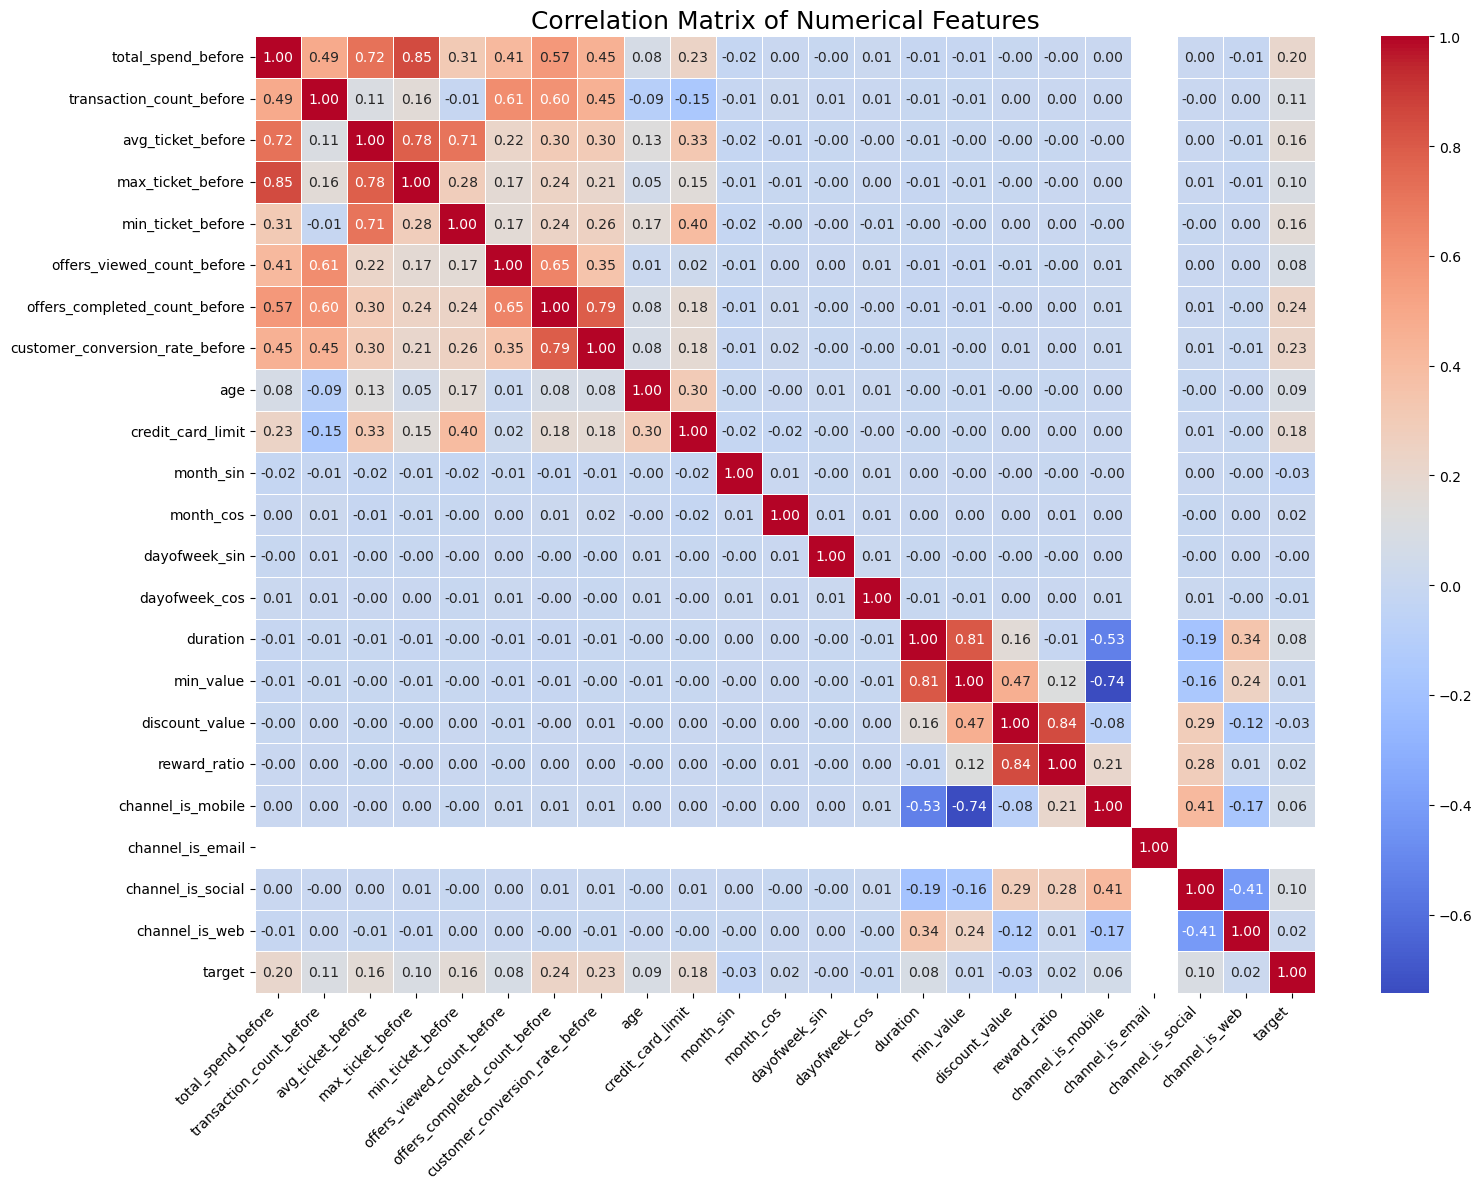

In [12]:
plot_correlation_matrix(df, numerical_columns + ["target"])


#### Key Insights from the Correlation Matrix

* **Strong Positive Correlations (Red Squares):**
    * **Customer Behavior Cluster:** There is a very strong positive correlation among features describing a customer's past spending and engagement. For example, `total_spend_before` is highly correlated with `transaction_count_before` (0.72) and `offers_viewed_count_before` (0.71). This is expected and confirms a clear pattern: customers who spend more are also the ones who transact more frequently and view more offers.
    * **Offer Value Cluster:** The features `min_value` (minimum value to activate an offer) and `discount_value` are highly correlated (0.81). This indicates a logical business rule: offers that require a higher spend also tend to give a proportionally higher discount. The `duration` is also strongly correlated with these two (0.81 and 0.81 respectively).

* **Moderate Positive Correlations:**
    * **Customer Conversion Rate:** The `customer_conversion_rate_before` shows a strong positive correlation (0.79) with `offers_completed_count_before`. This is a direct mathematical relationship, as the conversion rate is derived from the completed count. More importantly, it also has a moderate positive correlation with spending habits like `total_spend_before` (0.45), suggesting that historically active spenders are also more likely to have a higher conversion rate.

* **Negative Correlations (Blue Squares):**
    * The most notable negative correlation is between `channel_is_mobile` and `duration` (-0.53). This suggests that offers distributed via the mobile channel tend to have a significantly shorter duration than those on other channels. This could be a deliberate strategy to create urgency on a more immediate platform.

#### Business Implications for Modeling

1.  **Multicollinearity:** The strong correlations within the "Customer Behavior Cluster" (e.g., `total_spend_before` and `transaction_count_before`) indicate high multicollinearity. While tree-based models like LightGBM are generally robust to this, it's important to be aware of this redundancy. It confirms that these features are all capturing a similar underlying signal of "customer engagement." For simpler models, like logistic regression, we might need to select only one or two features from this cluster to avoid issues.
2.  **Feature Importance:** The heatmap shows that the `target` variable has the strongest positive correlations with behavioral features like `customer_conversion_rate_before` (0.23), `offers_completed_count_before` (0.24), and `total_spend_before` (0.20). This aligns perfectly with the SHAP analysis, confirming that a customer's past engagement is the most powerful predictor of their future success.
3.  **Offer Strategy Insight:** The relationships within the "Offer Value Cluster" and the negative correlation between `mobile` and `duration` provide a clear picture of the existing offer strategies, which can be leveraged or challenged by the model's findings.

### Model Train

In [13]:
lgbm_trainer = LGBMTrainer(df, numerical_columns, categorical_columns, "target")

2025-09-25 20:57:41,104 - ifood_case.model_trainer - INFO - ModelTrainer initialized


In [14]:
x_train, x_test, y_train, y_test = lgbm_trainer.train()

2025-09-25 20:57:41,124 - ifood_case.model_trainer - INFO - Starting model training and tuning process...
2025-09-25 20:57:41,125 - ifood_case.model_trainer - INFO - Splitting data into train and test sets based on last customer offer.
2025-09-25 20:57:41,167 - ifood_case.model_trainer - INFO - Converting Spark DataFrames to Pandas.


25/09/25 20:57:41 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

2025-09-25 20:57:46,904 - ifood_case.model_trainer - INFO - Splitting training data into a training subset and a calibration set.
2025-09-25 20:57:46,926 - ifood_case.model_trainer - INFO - Data split: 47426 train, 11857 calibration, 16994 test samples.
2025-09-25 20:57:46,932 - ifood_case.model_trainer - INFO - Starting OptunaSearchCV for LightGBM with 50 trials...
2025-09-25 21:00:49,588 - ifood_case.model_trainer - INFO - Optuna search complete. Best score (average_precision): 0.8639
2025-09-25 21:00:49,588 - ifood_case.model_trainer - INFO - Starting isotonic calibration step...
2025-09-25 21:00:49,620 - ifood_case.model_trainer - INFO - Calibration complete.


### Model Evaluate

In [15]:
evaluator = Evaluator(x_test, y_test)

2025-09-25 21:00:49,639 - ifood_case.evaluator - INFO - Evaluator initialized with 16994 test samples.


In [16]:
y_pred = lgbm_trainer.predict(x_test)

In [17]:
y_pred_proba = lgbm_trainer.predict_proba(x_test)

2025-09-25 21:00:49,756 - ifood_case.evaluator - INFO - Generating full evaluation report...
2025-09-25 21:00:49,770 - ifood_case.evaluator - INFO - Classification report generated.
2025-09-25 21:00:49,771 - ifood_case.evaluator - INFO - Plotting confusion matrix...


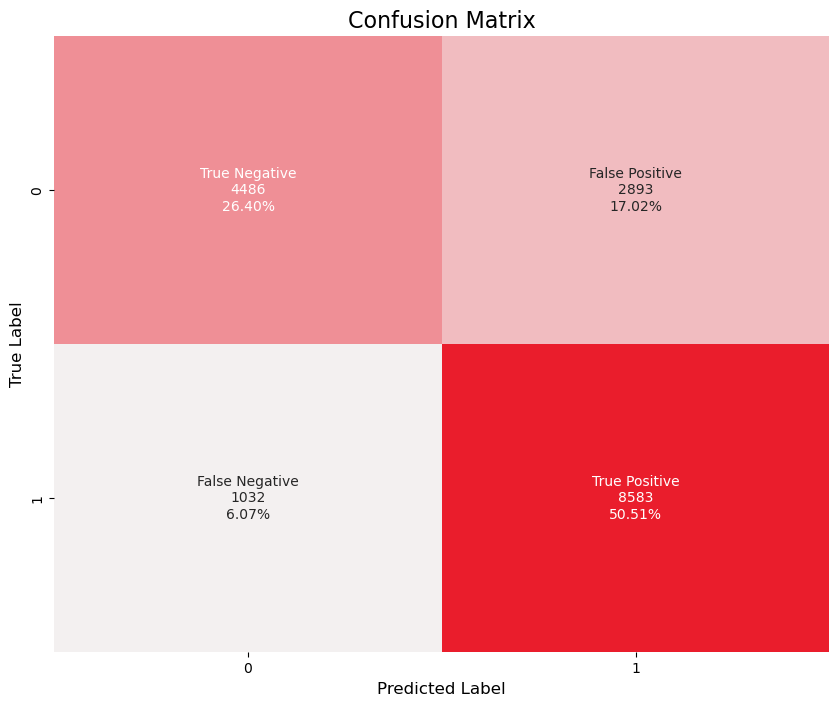

2025-09-25 21:00:49,845 - ifood_case.evaluator - INFO - Plotting Precision-Recall curve...


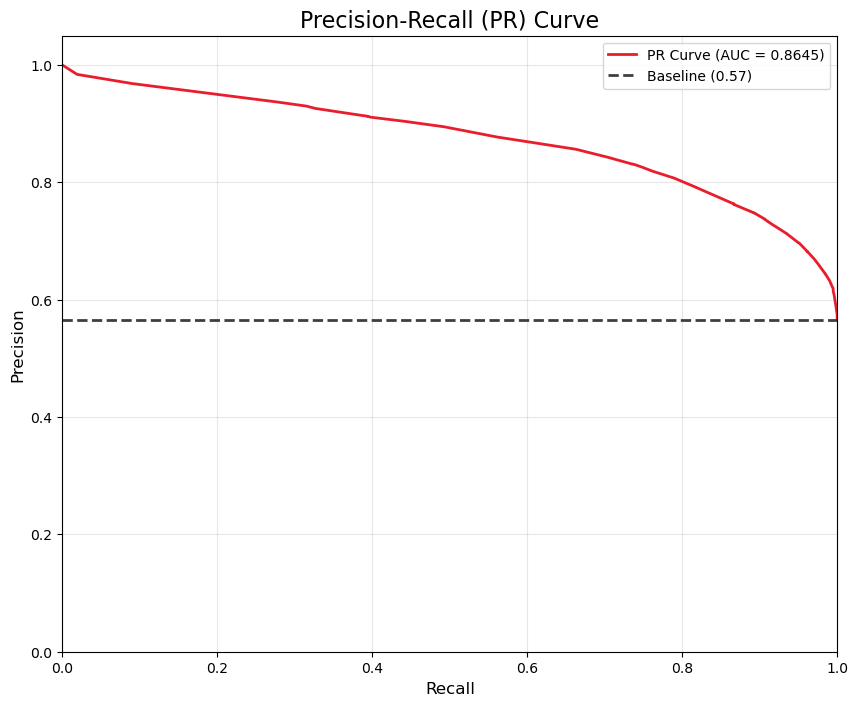

2025-09-25 21:00:49,942 - ifood_case.evaluator - INFO - Plotting ROC Curve...


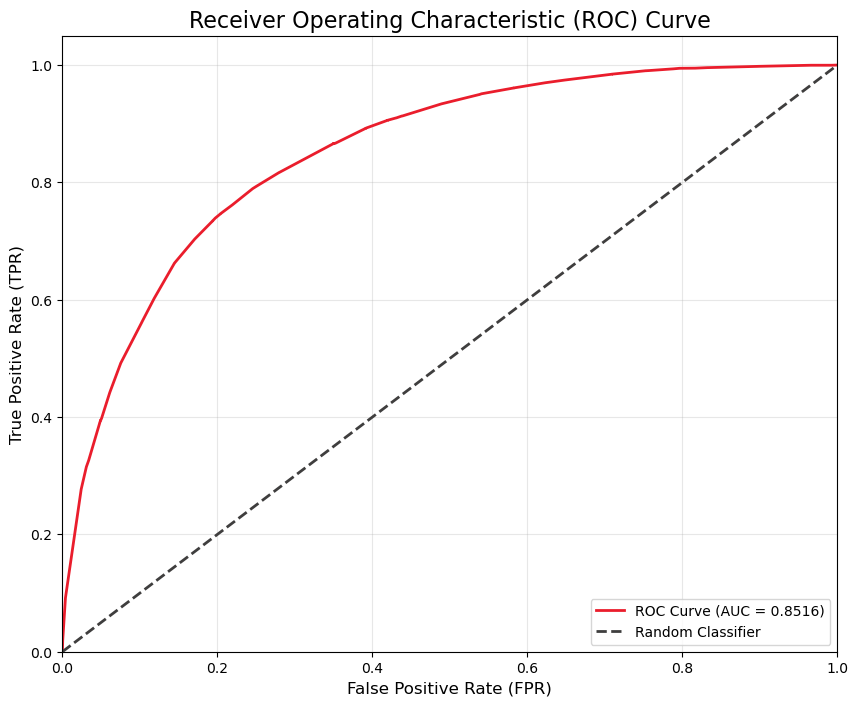

In [18]:
metrics = evaluator.report(y_pred, y_pred_proba)

#### Confusion Matrix: Classification Accuracy


The confusion matrix provides a detailed breakdown of the model's predictions versus the actual outcomes.

* **True Positives (8,583 | 50.51%):** The model correctly identified 8,583 instances where a customer would complete an offer. This represents the primary value driver of the model, as it successfully targets receptive customers.
* **True Negatives (4,486 | 26.40%):** The model correctly identified 4,486 instances where an offer would not be successful. This is crucial for cost savings, as it prevents sending offers to unresponsive customers.
* **False Positives (2,893 | 17.02%):** The model incorrectly predicted success for 2,893 offers that were not completed. This represents the cost of the model's errors, as these offers were sent unnecessarily.
* **False Negatives (1,032 | 6.07%):** The model failed to identify 1,032 customers who would have completed an offer. This represents a missed opportunity, which our model aims to minimize.

**Business Insight:** The model demonstrates a strong ability to find customers who will convert (a high number of True Positives) while maintaining a reasonably low number of missed opportunities (False Negatives). The key area for future optimization will be reducing the False Positives to further improve marketing budget efficiency.

---

#### ROC Curve: Model Discrimination Ability


The Receiver Operating Characteristic (ROC) curve evaluates the model's ability to distinguish between positive and negative classes.

* **AUC Score of 0.8516:** The Area Under the Curve (AUC) is a robust measure of overall model performance. A score of 0.85 indicates a very good level of discriminative power, significantly outperforming a random guess (the dashed line, AUC = 0.5).
* **Interpretation:** This means there is an 85% probability that the model will rank a randomly chosen positive instance (a customer who will convert) higher than a randomly chosen negative instance (a customer who will not convert).

**Business Insight:** An AUC of 0.85 demonstrates that the model is highly effective at identifying the right customers to target, providing a strong foundation for a data-driven campaign strategy.

---

#### Precision-Recall (PR) Curve: Performance on the Positive Class


The PR curve is especially important for this business problem, as it focuses on the performance of predicting the positive class (offer completion), which is often the minority class.

* **PR AUC Score of 0.8645:** The model achieves a PR AUC of 0.86, which is substantially higher than the "no-skill" baseline of 0.57 (the dotted line representing the natural conversion rate in the dataset).
* **Interpretation:** This curve shows the trade-off between Precision (of the customers we target, how many are correct?) and Recall (of all the customers who would convert, how many did we find?). The high area under the curve indicates that the model can maintain high precision even while identifying a large portion of all potential converters.

**Business Insight:** This strong PR curve performance is perhaps the most compelling result. It shows that the model is not just accurate overall, but it is specifically very good at the task that drives business value: finding customers who will complete offers, without having to send offers to a massive number of users who will not.

In [19]:
metrics["actual_conversion_rate_test (%)"]

np.float64(56.58)

In [20]:
metrics["model_conversion_rate (%)"]

np.float64(67.53)

In [21]:
metrics["classification_report"]

{'0': {'precision': 0.813,
  'recall': 0.6079,
  'f1-score': 0.6957,
  'support': 7379.0},
 '1': {'precision': 0.7479,
  'recall': 0.8927,
  'f1-score': 0.8139,
  'support': 9615.0},
 'accuracy': 0.769,
 'macro avg': {'precision': 0.7804,
  'recall': 0.7503,
  'f1-score': 0.7548,
  'support': 16994.0},
 'weighted avg': {'precision': 0.7762,
  'recall': 0.769,
  'f1-score': 0.7626,
  'support': 16994.0}}

### Model Performance Metrics: A Detailed Analysis

The following section breaks down the key performance indicators of our trained offer propensity model. The evaluation was conducted on a holdout test set, providing a reliable estimate of how the model would perform on new, unseen data.

#### 1. Conversion Rate Analysis: An Optimistic Predictor

* **Actual Conversion Rate in Test Set:** **56.58%**
* **Model's Predicted Conversion Rate:** **67.53%**

**Key Insight:**
The model predicts a higher conversion rate than what is observed in reality. This indicates that the model is "optimistic" and biased towards action—it identifies a larger group of customers as potential converters than actually exist.

**Business Implication:**
This is not necessarily a negative trait; it means the model is designed to maximize reach and capture as many opportunities as possible. However, this optimism comes at the cost of sending offers to some customers who will not ultimately convert, which has an impact on campaign efficiency and cost. This trade-off is further clarified by the precision and recall metrics.

---

#### 2. Classification Report: A Deeper Look at Precision and Recall


This report provides a detailed view of the model's performance for both predicting a "conversion" (class `1`) and a "non-conversion" (class `0`). For our business goal, we are most interested in the performance for class `1`.

**Key Insights for the "Conversion" Class (Class 1):**

* **Recall: 0.89 (89%)**
    * This is an excellent result and the model's strongest attribute. It means the model successfully finds **89% of all customers who would have actually completed an offer**.
    * **Business Value:** This high recall ensures that we are minimizing missed opportunities. We are effectively reaching the vast majority of our receptive audience.

* **Precision: 0.75 (75%)**
    * This metric tells us what happens when the model predicts a conversion. When the model recommends sending an offer (predicts `1`), it is correct **75% of the time**.
    * **Business Value:** This represents the "hit rate" of our targeted campaign. A 75% precision means that three out of every four offers sent based on the model's recommendation will result in a successful conversion, which is a very strong outcome. The remaining 25% are the False Positives that generate marketing costs without a direct return.

---

### 3. Overall Conclusion and Strategic Recommendation

The model demonstrates **strong and valuable performance**. Its primary strength is its **high recall**, ensuring we capture most of the potential revenue on the table. While its **precision is also good at 75%**, the model's optimistic nature (as seen in the conversion rate comparison) leads to a significant number of False Positives.

**Strategic Recommendation:**
The model, with its current 0.5 probability threshold, is well-suited for a business strategy focused on **growth and maximizing engagement**, as it prioritizes finding all potential converters.

However, if the business objective were to shift towards **maximizing profitability (ROI)**, especially if the cost of sending offers is high, the next step would be to **optimize the prediction threshold**. By increasing the threshold (e.g., only acting on predictions with >70% probability), we would increase the model's precision (reduce wasted offers) at the expense of some recall (missing some opportunities). The `find_optimal_threshold` function is the perfect tool for this next phase of analysis.

#### UP Lift

In [22]:
avg_conversion_value = x_train.loc[y_train == 1,:]['max_ticket_before'].mean()

In [23]:
results_df = find_optimal_threshold(evaluator, y_pred_proba, avg_conversion_value, OFFER_COST)

2025-09-25 21:00:50,132 - ifood_case.utils - INFO - Starting search for optimal financial threshold...
2025-09-25 21:00:50,133 - ifood_case.evaluator - INFO - Calculating financial uplift...
2025-09-25 21:00:50,134 - ifood_case.evaluator - INFO - Financial Uplift Calculated: $4790.23
2025-09-25 21:00:50,135 - ifood_case.evaluator - INFO - Calculating financial uplift...
2025-09-25 21:00:50,137 - ifood_case.evaluator - INFO - Financial Uplift Calculated: $4589.50
2025-09-25 21:00:50,137 - ifood_case.evaluator - INFO - Calculating financial uplift...
2025-09-25 21:00:50,139 - ifood_case.evaluator - INFO - Financial Uplift Calculated: $3899.42
2025-09-25 21:00:50,139 - ifood_case.evaluator - INFO - Calculating financial uplift...
2025-09-25 21:00:50,141 - ifood_case.evaluator - INFO - Financial Uplift Calculated: $2920.53
2025-09-25 21:00:50,141 - ifood_case.evaluator - INFO - Calculating financial uplift...
2025-09-25 21:00:50,143 - ifood_case.evaluator - INFO - Financial Uplift Calculat

#### Key Insights from the Threshold Analysis

* **Optimal Threshold for Profitability:** The analysis reveals that the optimal decision threshold is **0.05**. At this threshold, the model generates the highest possible financial uplift of **$4,790.23** compared to the baseline strategy of sending offers to everyone.

* **The Profitability Cliff:** The model's profit and financial uplift are positive only at very low thresholds (0.05 to 0.25). As the threshold increases beyond 0.25, the financial uplift becomes sharply **negative**. This indicates that being too "strict" with who receives an offer causes us to miss too many valuable opportunities (False Negatives), making the strategy less profitable than the baseline.

* **High Precision vs. High Profit:** At high thresholds (e.g., 0.85 and above), the model is extremely precise—it only targets customers it is very sure about. However, this excludes so many potential customers that the total profit becomes deeply negative. This demonstrates the critical trade-off between precision and overall business value.

* **Point of Attetion**: We are using a simulated offer cost of 0.5

#### Strategic Recommendation

**The primary recommendation is to deploy the model using a decision threshold of 0.05.**

* **Business Implication:** By targeting a larger audience that the model identifies as having at least a 5% chance of converting, we capture the maximum number of profitable opportunities. The model is still providing significant value by excluding the most unlikely customers, which is what drives the nearly $4,800 in financial uplift. Adopting this low-threshold strategy moves our focus from pure prediction accuracy to **maximizing the financial return** of the marketing campaign.

### Model Explanation

2025-09-25 21:00:50,190 - ifood_case.evaluator - INFO - Starting SHAP summary plot generation...
2025-09-25 21:00:50,191 - ifood_case.evaluator - INFO - Transform test data for SHAP analysis.
2025-09-25 21:00:50,205 - ifood_case.evaluator - INFO - Calculating SHAP values...(this may take a moment)
2025-09-25 21:00:52,331 - ifood_case.evaluator - INFO - Plotting SHAP summary...


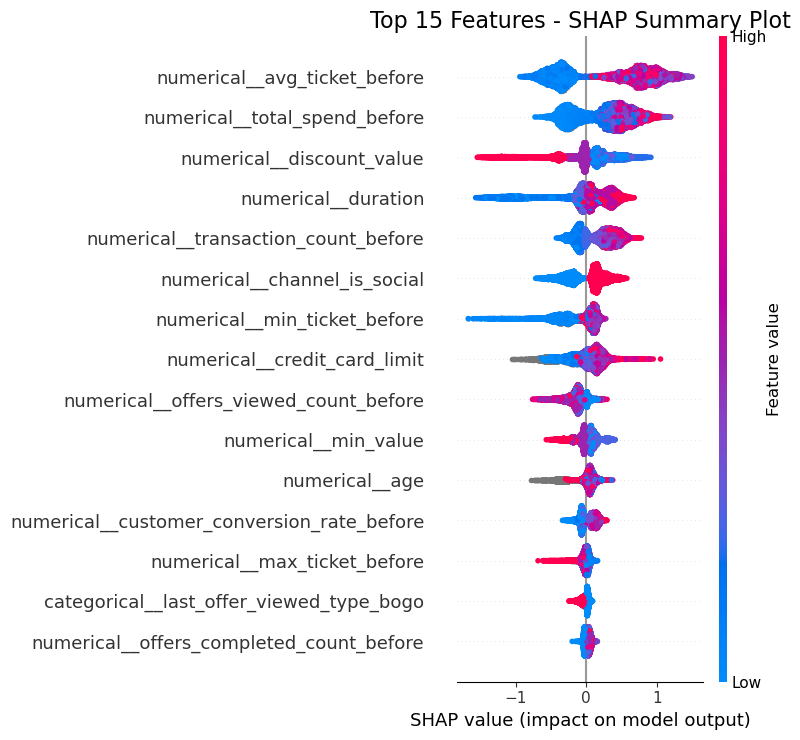

In [24]:
evaluator.plot_shap_summary(lgbm_trainer.estimator)

### Model Interpretability: SHAP Feature Impact Analysis

**How to Read This Plot:**
* **Feature Importance:** Features are ranked from most impactful (top) to least impactful (bottom).
* **Impact on Prediction (X-axis):** SHAP values greater than zero push the prediction towards "Success" (target=1). Values less than zero push it towards "Failure" (target=0).
* **Feature Value (Color):** Red dots represent high values for a feature (e.g., high spending), while blue dots represent low values.

---

### Key Drivers of Offer Success

The model has learned to identify several key behavioral and offer-specific patterns.

* **Customer Spending Habits are Paramount:**
    * **Insights:** The two most important features are `avg_ticket_before` and `total_spend_before`. For both, high values (red dots) have a strong positive SHAP value, meaning customers who historically spend more per transaction and have a higher total spend are significantly more likely to complete an offer.
    * **Agreement with EDA:** This confirms and quantifies our EDA finding. We saw a highly active group of "Uses Offers"; the model has now confirmed that this high-spending behavior is the single most important predictor of future success.

* **Offer Characteristics Matter:**
    * **Insights:** The `discount_value` and `duration` of an offer are highly influential. As expected, higher discounts (red dots) increase the likelihood of completion. Interestingly, the model found that shorter `duration` offers (blue dots) have a higher positive impact, suggesting that a sense of urgency is a powerful motivator.
    * **New Information:** This is a new, powerful insight not visible in the initial EDA. While we analyzed channels, we hadn't quantified the impact of offer structure. The model suggests that short-duration, high-value discounts are a potent combination.

* **Customer Engagement is a Strong Predictor:**
    * **Insights:** Features like `transaction_count_before` and `customer_conversion_rate_before` are also top predictors. Customers who transact frequently and have a history of completing offers (high, red values) are very likely to complete future offers.
    * **Agreement with EDA:** This reinforces the pattern that past engagement is a strong indicator of future engagement. The model is effectively learning to identify our loyal and active customer base.

---

### Deep Dive: The Surprising Impact of the 'Social' Channel

One of the most valuable insights comes from comparing the SHAP analysis to our initial exploratory data analysis (EDA), specifically regarding the `channel_is_social` feature.

* **The Apparent Contradiction:**
    * Our **EDA** showed that the `social` channel had the **lowest overall conversion rate** (51.1%) among all channels. A simple analysis might suggest deprioritizing it.
    * However, the **SHAP plot** shows that `channel_is_social` is the **6th most important feature**, and its presence (`1`, red dots) has a clear and strong **positive impact** on the model's prediction for success.

* **What This Means (Correlation vs. Model Insight):**
    This is a classic example of the power of a machine learning model. The EDA shows a simple average, but the model analyzes complex interactions. The model has learned that while the `social` channel may not be effective for the *average* customer, it is **highly effective for specific segments or when used in certain combinations**.

* **Strategic Recommendation:**
    Instead of reducing investment in the social channel based on its low overall conversion rate, this insight tells us to do the opposite: **we should use the model to find and target the specific customers for whom the social channel is a key motivator.** The model has uncovered a valuable, non-obvious pattern that simple analytics would have missed. This finding alone can lead to a more efficient and nuanced marketing strategy, preventing us from cutting a channel that is highly effective for a valuable niche audience.